# Forecast of COVID-19 (new) deaths in French hospitals

In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fbprophet import Prophet
import warnings
import logging

logging.getLogger("fbprophet").setLevel(logging.WARNING)
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()

In [3]:
figsize = (12, 7)
covid_url = (
    "https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7"
)
nb_days = 4  # forecast horizon (days)

#### <br> Load COVID-19 data of French departments

In [4]:
df = pd.read_csv(covid_url, sep=";", parse_dates=True, index_col=2)
df = df.query("sexe == 0")  # sum male/female
df.drop(columns=["sexe"], inplace=True)
df.sort_index(inplace=True)
df.head(2)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,dep,hosp,rea,rad,dc
jour,,,,,
2020-03-18,01,2,0,1,0
2020-03-18,02,41,10,18,11


#### <br> Aggregate death data on France

In [5]:
ddf = df.groupby(df.index).sum()
ddf["delta_dc"] = (ddf["dc"] - ddf["dc"].shift()).fillna(0).astype(int)
dc = ddf[["dc", "delta_dc"]]
dc.head()

,dc,delta_dc
jour,,
2020-03-18,218,0
2020-03-19,327,109
2020-03-20,450,123
2020-03-21,525,75
2020-03-22,632,107


#### <br> Plot historical death data

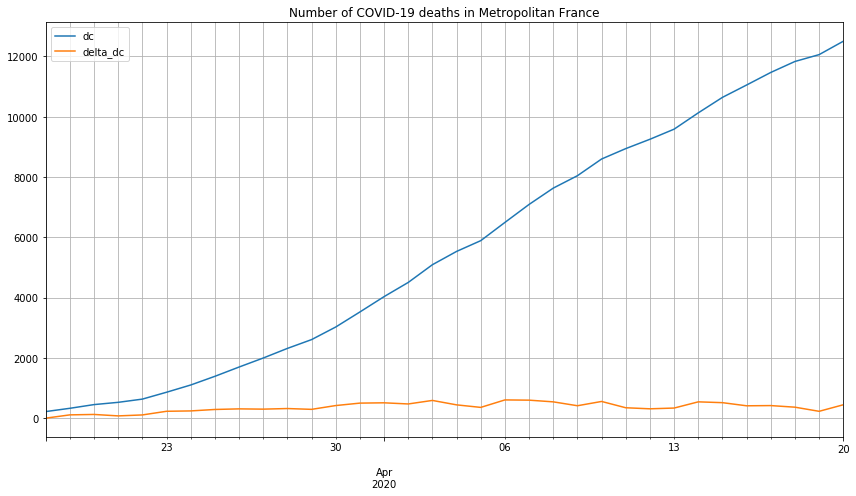

In [6]:
f, ax = plt.subplots(figsize=figsize)
dc.plot(ax=ax, subplots=False, sharex=True, grid=True)
ax.grid(True, which="both")
ax.set_title("Number of COVID-19 deaths in Metropolitan France")
img_name = "death_historical.png"
ax.xaxis.set_label_text("")
plt.tight_layout()
# f.savefig(img_name)
plt.show()

#### <br> Build vector for Prophet learning

In [7]:
vec = dc.copy()
vec = vec.reset_index()
vec = vec[["jour", "delta_dc"]]
vec.rename(columns={"jour": "ds", "delta_dc": "y"}, inplace=True)
vec.head(2)

,ds,y
0,2020-03-18,0
1,2020-03-19,109


#### <br> Forecasting with Prophet

In [8]:
m = Prophet(n_changepoints=1)
m.fit(vec)

In [9]:
m.changepoints

26   2020-04-13
Name: ds, dtype: datetime64[ns]

In [10]:
future = m.make_future_dataframe(periods=nb_days)
forecast = m.predict(future)

#### <br> Plot forecast and inflection points

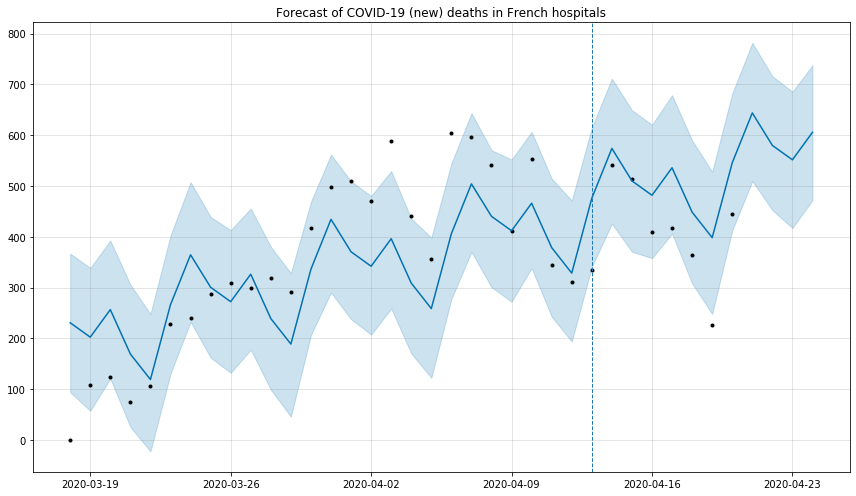

In [11]:
f, ax = plt.subplots(figsize=figsize)
figure = m.plot(forecast, ax=ax)
ax.set_title("Forecast of COVID-19 (new) deaths in French hospitals")
ax.xaxis.set_label_text("")
ax.yaxis.set_label_text("")
for changepoint in m.changepoints:
    plt.axvline(changepoint, ls="--", lw=1)
img_name = "death_forecast.png"
plt.tight_layout()
f.savefig(img_name)